In [101]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [102]:
n_in = 168 #历史数量
n_out = 24 #预测数量
n_features = 1
# n_test = 1
n_val = 1
n_epochs = 250

In [103]:
#d导入数据
def load_stw_data() -> pd.DataFrame:
    
    df_stw = pd.read_excel('data3.xlsx')
    df_stw.columns = ['BillingDate', 'VolumnHL']
    
    return df_stw

In [104]:
#MinMaxScaler数据归一化，可以帮助网络模型更快的拟合，稍微有一些提高准确率的效果
def minmaxscaler(data: pd.DataFrame) -> pd.DataFrame:
    
    volume = data.VolumnHL.values
    volume = volume.reshape(len(volume), 1)
    volume = scaler.fit_transform(volume)
    volume = volume.reshape(len(volume),)    
    data['VolumnHL'] = volume
        
    return data

In [105]:
#划分训练数据集和验证数据集,这里需要注意的是我么需要预测的数据是不可以出现在训练中的，切记。
def split_data(x, y, n_test: int):
    
    x_train = x[:-n_val-n_out+1]
    x_val = x[-n_val:]
    y_train = y[:-n_val-n_out+1]
    y_val = y[-n_val:]
    
    return x_train, y_train, x_val, y_val

In [106]:
#划分X和Y
def build_train(train, n_in, n_out):
    
    train = train.drop(["BillingDate"], axis=1)
    X_train, Y_train = [], []
    for i in range(train.shape[0]-n_in-n_out+1):
        X_train.append(np.array(train.iloc[i:i+n_in]))
        Y_train.append(np.array(train.iloc[i+n_in:i+n_in+n_out]["VolumnHL"]))
        
    return np.array(X_train), np.array(Y_train)

In [115]:
#构建最简单的LSTM
def build_lstm(n_in: int, n_features: int):
    
    model = Sequential()
    model.add(LSTM(12, activation='relu', input_shape=(n_in, n_features)))
    model.add(Dropout(0.3))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mae')
    
    return model

In [116]:
#模型拟合
def model_fit(x_train, y_train, x_val, y_val, n_features):
    
    model = build_lstm(
        n_in   = n_in,
        n_features= 1
    )
    model.compile(loss='mae', optimizer='adam')
    model.fit(x_train, y_train, epochs=n_epochs, batch_size=128, verbose=1,  validation_data=(x_val, y_val))
    m = model.evaluate(x_val, y_val)
    print(m)
    
    return model

In [117]:
data = load_stw_data()
scaler = MinMaxScaler(feature_range=(0, 1))
data = minmaxscaler(data)

In [118]:
data_copy = data.copy()
x, y = build_train(data_copy, n_in, n_out)
x_train, y_train, x_val, y_val = split_data(x, y, n_val)
model = build_lstm(n_in, 1)
model = model_fit(x_train, y_train, x_val, y_val, 1)
predict = model.predict(x_val)  

Train on 529 samples, validate on 1 samples
Epoch 1/250
529/529 [==============================] - 1s 2ms/step - loss: 0.5863 - val_loss: 0.5720
Epoch 2/250
529/529 [==============================] - 0s 553us/step - loss: 0.5757 - val_loss: 0.5597
Epoch 3/250
529/529 [==============================] - 0s 585us/step - loss: 0.5647 - val_loss: 0.5466
Epoch 4/250
529/529 [==============================] - 0s 558us/step - loss: 0.5539 - val_loss: 0.5325
Epoch 5/250
529/529 [==============================] - 0s 531us/step - loss: 0.5419 - val_loss: 0.5196
Epoch 6/250
529/529 [==============================] - 0s 579us/step - loss: 0.5283 - val_loss: 0.5045
Epoch 7/250
529/529 [==============================] - 0s 573us/step - loss: 0.5110 - val_loss: 0.4839
Epoch 8/250
529/529 [==============================] - 0s 524us/step - loss: 0.4892 - val_loss: 0.4570
Epoch 9/250
529/529 [==============================] - 0s 573us/step - loss: 0.4584 - val_loss: 0.4308
Epoch 10/250
529/529 [=========

In [119]:

# predict = model.predict(x_val)  
validation = scaler.inverse_transform(predict)[0]
validation

array([629652.06, 601111.1 , 580061.75, 553453.94, 522222.25, 496213.34,
       487906.25, 484180.66, 486937.56, 498088.5 , 512388.75, 527296.56,
       550159.8 , 580237.  , 612543.5 , 646128.7 , 680854.56, 705669.2 ,
       716264.9 , 732494.75, 725075.06, 710319.5 , 689452.56, 662935.2 ],
      dtype=float32)

In [120]:
actual = scaler.inverse_transform(y_val)[0]
actual

array([639457., 620449., 611584., 493739., 323143., 329209., 350783.,
       403793., 449446., 489899., 528206., 563321., 594820., 608519.,
       616327., 626740., 640685., 673864., 739997., 789165., 818590.,
       804708., 748938., 694595.])

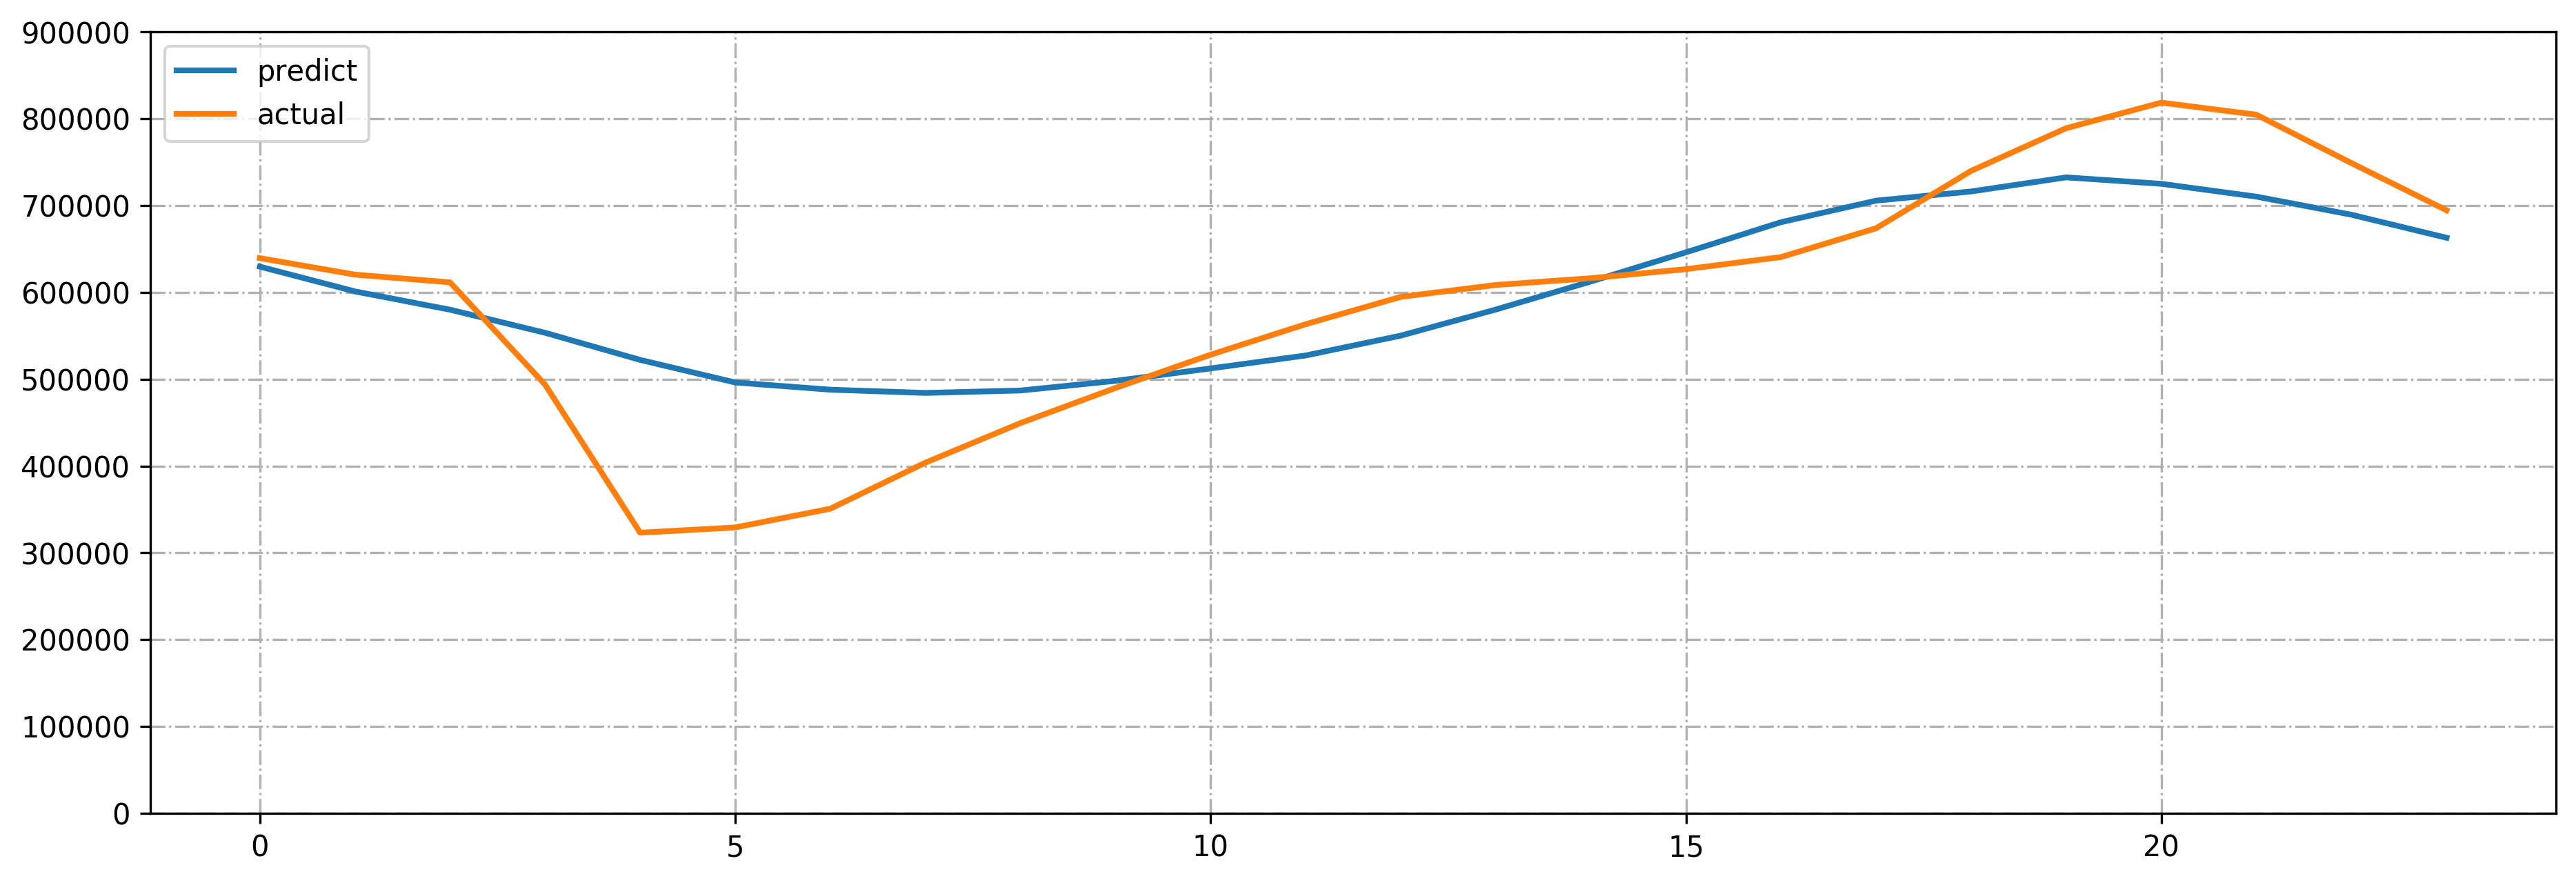

In [121]:
predict = validation
actual = actual
x = [x for x in range(24)]
fig, ax = plt.subplots(figsize=(15,5),dpi = 300)
ax.plot(x, predict, linewidth=2.0,label = "predict")
ax.plot(x, actual, linewidth=2.0,label = "actual")
ax.legend(loc=2);
# ax.set_title(bf_name)
plt.ylim((0, 900000))
plt.grid(linestyle='-.')
plt.show()

In [114]:
#ACC
error = 0
summery = 0
for i in range(24):
    error += abs(predict[i] - actual[i])
    summery += actual[i]
acc = 1 - error/summery
acc

0.8520669472132617